<i>DISCLAIMER:<br>
Bellow code is only for informative purpose, i renounce any responsibility regarding this code and bellow trained model causing loss of money during trading on real market.</i>

# Stock price prediction : AAPL

This page does following:

<b>1. Loading and preparation</b>
- Load data and libraries
- Normalize data based on linear scaling formula
- Split data to train and validation set (train 80%, validation 20%)
- Transform train and validation set into windows, each window has 4 rows (candles), first 3 rows represents formation the model is trained on, the 4th row is label (target price, the model will predict). Windowed data are transformed to tensors for future model training<br>

<b>2. Fun part - model training</b>
- Entry price is High price of 3rd row in window (last high price of formation we are trading)
- Model predicts high price of 4th candle (the last candle in the window)
- CNN + LSTM model is trained and compared to validation dataset used during training
- After model is trained, we let model predict prices on validation dataset<br>

<b>3. Result evaluation</b>
- New dataframe is created with predicted values, normalized data are reverted back to initial values
- We calculate  profit/loss per each trade on validation dataset and final balance is displayed
- Each trade is displayed in chart with target value, predicted value and entry price that trade was entered
- As the last step, prediction of the most recent stock data is made (please refer to page 03_Model_prediction

# 1. Loading and preparation

In [4]:
import tensorflow as tf
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

path = "AAPL_raw.csv"

data = pd.read_csv(path)
data.head(12)


2.5.0


,Date,Open,High,Low,Close,EMA4,EMA8,EMA16,trades
0,2000-01-21,1.020089,1.020089,0.983817,0.993862,0.970014,0.941744,NaN,1
1,2000-01-24,0.968192,1.006696,0.938616,0.948661,0.961473,0.943281,0.910819,1
2,2000-01-25,0.937500,1.010045,0.914063,1.002232,0.977776,0.956381,0.921573,1
3,2000-01-26,0.982143,1.019531,0.979911,0.983817,0.980193,0.962478,0.928896,1
4,2000-02-02,0.899554,0.911830,0.866071,0.882254,0.906646,0.923982,0.921722,2
5,2000-02-03,0.895647,0.930804,0.895089,0.922433,0.912961,0.923638,0.921806,2
6,2000-02-04,0.928013,0.982143,0.925223,0.964286,0.933491,0.932671,0.926804,2
7,2000-02-07,0.964286,1.020089,0.945871,1.018415,0.967461,0.951725,0.937581,2
8,2000-02-03,0.895647,0.930804,0.895089,0.922433,0.912961,0.923638,0.921806,3
9,2000-02-04,0.928013,0.982143,0.925223,0.964286,0.933491,0.932671,0.926804,3


<b>Get data and plot chart</b>

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title("AAPL close price")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

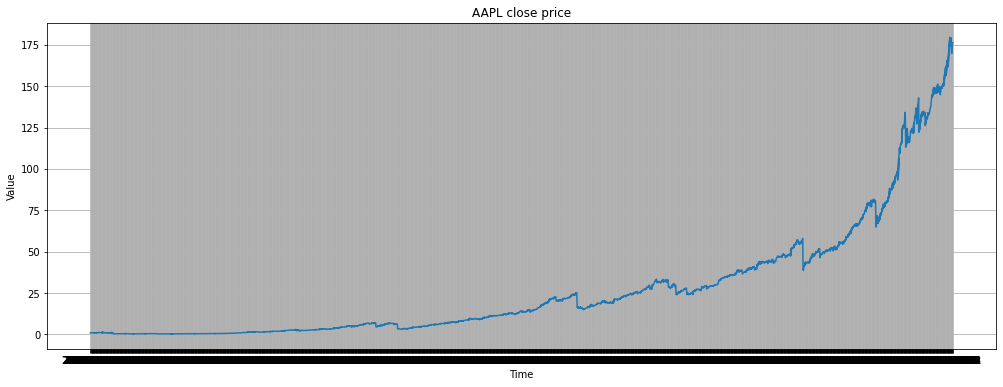

In [6]:
import csv
time_step = []

opens = []
highs = []
lows = []
closes = []
ema1 = []
ema2 = []
ema3 = []
new = []
final = []

with open(path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
   # next(reader)

    for row in reader:
        #print(row)
        
        time_step.append(row[0])
        opens.append(float(row[1]))
        highs.append(float(row[2]))
        lows.append(float(row[3]))
        closes.append(float(row[4]))
        ema1.append(row[5])
        ema2.append(row[6])
        ema3.append(row[7])

        
#Get series
series = np.array(closes[::])
time = np.array(time_step[::])

#Plot chart
plt.figure(figsize=(17, 6))
plot_series(time, series)


Get data in dataframe and prepare for windowing, we will be getting windows of 4 candles each, thus we need to have dataframe divisible by 4

In [7]:
dicti = {'Date':time,
         'opens':opens,
         'high':highs,
         'low':lows,
         'close':closes,
         'ema4':ema1,
         'ema8':ema2,
         'ema16':ema3}

temp_old = pd.DataFrame(dicti)
temp_old.head(7)

,Date,opens,high,low,close,ema4,ema8,ema16
0,2000-01-21,1.020089,1.020089,0.983817,0.993862,0.9700139626261103,0.9417441510527981,
1,2000-01-24,0.968192,1.006696,0.938616,0.948661,0.9614727893112008,0.9432812351163622,0.9108189381659031
2,2000-01-25,0.937500,1.010045,0.914063,1.002232,0.9777764557980242,0.9563813952078949,0.9215734107967686
3,2000-01-26,0.982143,1.019531,0.979911,0.983817,0.9801926660050596,0.962478192120721,0.9288961837989855
4,2000-02-02,0.899554,0.911830,0.866071,0.882254,0.906646261048153,0.9239816587150149,0.9217222457436947
5,2000-02-03,0.895647,0.930804,0.895089,0.922433,0.9129609641026467,0.9236375164859866,0.9218058660896585
6,2000-02-04,0.928013,0.982143,0.925223,0.964286,0.9334909901971227,0.9326705193421755,0.9268035323542677


Fill empty values

In [8]:
temp_old.loc[0,'ema16'] = 0.910818938165903
temp_old['ema16'] = temp_old['ema16'].astype('float64')
temp_old['ema8'] = temp_old['ema8'].astype('float64')
temp_old['ema4'] = temp_old['ema4'].astype('float64')
temp_old.head(3)
temp_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4344 non-null   object 
 1   opens   4344 non-null   float64
 2   high    4344 non-null   float64
 3   low     4344 non-null   float64
 4   close   4344 non-null   float64
 5   ema4    4344 non-null   float64
 6   ema8    4344 non-null   float64
 7   ema16   4344 non-null   float64
dtypes: float64(7), object(1)
memory usage: 271.6+ KB


Get dataframe divisible by 4, since <b>3 candles represents formation</b>, 1 candle is label

In [9]:
print("Initial length of dataframe: ",len(temp_old))
formations = int(len(temp_old)/4)
print("Nr of formations: ", formations)
ttl = int(formations*4)
print("New length of dataframe: ",ttl)

Initial length of dataframe:  4344
Nr of formations:  1086
New length of dataframe:  4344


<b>Get final dataframe</b>
- <b>If needed Reshuffling MUST be done here</b>
- get temp dataframe that has excluded Date column
- get new Dates column separately for future reference

In [10]:
initial_df = temp_old.iloc[:ttl,1:]
len_initial = len(initial_df)
print("Len initial_df: ",len_initial)
initial_df.head(2)

Len initial_df:  4344


,opens,high,low,close,ema4,ema8,ema16
0,1.020089,1.020089,0.983817,0.993862,0.970014,0.941744,0.910819
1,0.968192,1.006696,0.938616,0.948661,0.961473,0.943281,0.910819


In [11]:
Dates = temp_old.iloc[:len_initial,0]
Dates.head(2)

0    2000-01-21
1    2000-01-24
Name: Date, dtype: object

In [12]:
df1 = initial_df.head(8)
df1

,opens,high,low,close,ema4,ema8,ema16
0,1.020089,1.020089,0.983817,0.993862,0.970014,0.941744,0.910819
1,0.968192,1.006696,0.938616,0.948661,0.961473,0.943281,0.910819
2,0.937500,1.010045,0.914063,1.002232,0.977776,0.956381,0.921573
3,0.982143,1.019531,0.979911,0.983817,0.980193,0.962478,0.928896
4,0.899554,0.911830,0.866071,0.882254,0.906646,0.923982,0.921722
5,0.895647,0.930804,0.895089,0.922433,0.912961,0.923638,0.921806
6,0.928013,0.982143,0.925223,0.964286,0.933491,0.932671,0.926804
7,0.964286,1.020089,0.945871,1.018415,0.967461,0.951725,0.937581


In [13]:
#tf.expand_dims(df1,axis=0)
#arr_3D = df1.values.reshape(-1,4,56)
#arr_3D

<b>Normalize data</b>

Linear scaling formula: <i>x ′ = ( x − x m i n ) / ( x m a x − x m i n )</i><br>
Reverse linear scaling: <i>x = (x * (maxv-minv)) + minv</i>

Bellow code will take window size which represents formation that is to be traded, and normalize data exactly per window that is alocated. Each window is normalized separately on each other, using linear scaling formula from above

<b>Set Window Size and Normalize based on windows</b>

Set window size and normalize entire dataset before modelling

In [14]:
window_size = 3+1

batch_size = 64 #Train batchsize

batch_valid = 32 #Valid batchsize

tf.random.set_seed(7788)
np.random.seed(7788)


In [15]:
def Normalize(df,window_size):
    """
    Get dataframe and window_size as an input
    
    Normalize data based on linear scaling formula
    
    save maxv and minv of each window for future reversion
    
    """
    
    print("\nNormalize dataframe \n")
    
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_norm = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df),window_size):
        
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df.shape[1]: 

            #Get max High
            if row + inc<len(df):
                
                Highs.append(df.iloc[row+inc][1])
                Lows.append(df.iloc[row+inc][2])

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        #Save Max and Min
        maxv = max(Highs)
        minv = min(Lows)
        
        #testing
        maxv = np.max(df.iloc[row:row + window_size,:].to_numpy())
        minv = np.min(df.iloc[row:row + window_size,:].to_numpy())
        #print(maxv)
        #print(minv)
        #break
        #Reset 
        Highs = []
        Lows = []

        #Print first 2 windows for checking
        if counter < 3:
            #Print data windowing
            print("\nWindow:" + str(counter) + "\n " + str(df.iloc[row:row + window_size,:]))
            print("\nMax value is ", maxv)
            print("Min value is ", minv)
            print("\n Normalized:\n "+ str((df.iloc[row:row + window_size,:]-minv)/(maxv-minv)))

        #Merge normalized window to new dataframe
        df_temp = (df.iloc[row:row + window_size,:]-minv)/(maxv-minv)
        df_temp['maxv'] = maxv
        df_temp['minv'] = minv

        df_norm = pd.concat([df_norm,df_temp],axis=0)     

    print("\nDone")
    
    return df_norm
    
df_norm = Normalize(initial_df,window_size)


Normalize dataframe 


Window:1
       opens      high       low     close      ema4      ema8     ema16
0  1.020089  1.020089  0.983817  0.993862  0.970014  0.941744  0.910819
1  0.968192  1.006696  0.938616  0.948661  0.961473  0.943281  0.910819
2  0.937500  1.010045  0.914063  1.002232  0.977776  0.956381  0.921573
3  0.982143  1.019531  0.979911  0.983817  0.980193  0.962478  0.928896

Max value is  1.020089030265808
Min value is  0.910818938165903

 Normalized:
       opens      high       low     close      ema4      ema8         ema16
0  1.000000  1.000000  0.668051  0.759980  0.541731  0.283016  0.000000e+00
1  0.525057  0.877432  0.254388  0.346317  0.463566  0.297083  1.016036e-15
2  0.244175  0.908081  0.029688  0.836579  0.612771  0.416971  9.842101e-02
3  0.652732  0.994893  0.632306  0.668051  0.634883  0.472767  1.654364e-01

Window:2
       opens      high       low     close      ema4      ema8     ema16
4  0.899554  0.911830  0.866071  0.882254  0.906646  0.923982  

Check <b>not normalized</b> dataframe initial_df

In [16]:
initial_df.tail()

,opens,high,low,close,ema4,ema8,ema16
4339,179.279999,181.139999,170.750000,172.259995,174.890402,173.634109,169.600918
4340,168.279999,170.580002,167.460007,169.750000,171.934145,172.339893,169.778223
4341,171.559998,173.199997,169.119995,172.990005,172.356489,172.484362,170.156080
4342,173.039993,175.860001,172.149994,175.639999,173.669893,173.185615,170.801247
4343,175.850006,176.850006,175.270004,176.279999,174.713935,173.873256,171.445806


Check <b>normalized</b> dataframe df_norm

In [17]:
df_norm.tail(4)

,opens,high,low,close,ema4,ema8,ema16,maxv,minv
4340,0.087326,0.332268,0.000000,0.243876,0.476479,0.519690,0.246881,176.850006,167.460007
4341,0.436634,0.611288,0.176783,0.588924,0.521457,0.535075,0.287122,176.850006,167.460007
4342,0.594248,0.894568,0.499466,0.871139,0.661330,0.609756,0.355830,176.850006,167.460007
4343,0.893504,1.000000,0.831736,0.939296,0.772516,0.682987,0.424473,176.850006,167.460007


We have added additional columns maxv and minv to each row, this is needed due to future need to revert normalized values back to its initial ones.

<b>Split normalized data to train and validation set</b>

In [18]:
print("dfnorm ",len(df_norm))
ttl = len(df_norm)/window_size

print("df_norm / windowsize: ",ttl)

new_ttl = ttl*window_size
print("total len: ", new_ttl)
trainsubset = round(new_ttl*0.8,0)
print("get 80% of train set: ", trainsubset)
train_windows = round(trainsubset/4,0)
print("total windows of 80% train set: ",train_windows)

ttl_xtrain = train_windows*4
print("\ntotal x_train: ",ttl_xtrain)

print("total x_val: ",(-ttl_xtrain)+len(df_norm))

dfnorm  4344
df_norm / windowsize:  1086.0
total len:  4344.0
get 80% of train set:  3475.0
total windows of 80% train set:  869.0

total x_train:  3476.0
total x_val:  868.0


In [19]:
print("ttl x_train,",ttl_xtrain)
split = int(ttl_xtrain)

time_train = time[:split]
x_train = df_norm[:split]
time_valid = time[split:]
x_valid = df_norm[split:]


ttl x_train, 3476.0


Display normalized train set

In [24]:
x_train.head(4)

,opens,high,low,close,ema4,ema8,ema16,maxv,minv
0,1.000000,1.000000,0.668051,0.759980,0.541731,0.283016,0.000000e+00,1.020089,0.910819
1,0.525057,0.877432,0.254388,0.346317,0.463566,0.297083,1.016036e-15,1.020089,0.910819
2,0.244175,0.908081,0.029688,0.836579,0.612771,0.416971,9.842101e-02,1.020089,0.910819
3,0.652732,0.994893,0.632306,0.668051,0.634883,0.472767,1.654364e-01,1.020089,0.910819


In [25]:
x_train_extremes = x_train.iloc[:,7:].copy()
print("Len x_train_extremes: ",len(x_train_extremes))
x_train_extremes.head(1)

Len x_train_extremes:  3476


,maxv,minv
0,1.020089,0.910819


In [26]:
x_valid_extremes = x_valid.iloc[:,7:].copy()
print("len x_valid_extremes: ",len(x_valid_extremes))
x_valid_extremes.head(1)

len x_valid_extremes:  868


,maxv,minv
3476,52.3125,48.039809


<b>Get x_train and x_valid without extreme minv maxv values</b>

In [27]:
x_valid = x_valid.iloc[:,:7].copy()
x_train = x_train.iloc[:,:7].copy()
x_train

,opens,high,low,close,ema4,ema8,ema16
0,1.000000,1.000000,0.668051,0.759980,0.541731,0.283016,0.000000e+00
1,0.525057,0.877432,0.254388,0.346317,0.463566,0.297083,1.016036e-15
2,0.244175,0.908081,0.029688,0.836579,0.612771,0.416971,9.842101e-02
3,0.652732,0.994893,0.632306,0.668051,0.634883,0.472767,1.654364e-01
4,0.217397,0.297102,0.000000,0.105072,0.263445,0.375999,3.613295e-01
...,...,...,...,...,...,...,...
3471,0.596064,1.000000,0.584153,0.948731,0.570117,0.395006,2.527749e-01
3472,0.049485,0.144330,0.000000,0.048969,0.085991,0.106064,8.112387e-02
3473,0.504639,0.640206,0.410825,0.626804,0.302316,0.221784,1.453215e-01
3474,0.579381,0.981443,0.567526,0.930412,0.553555,0.379257,2.376851e-01


<b>Get windowed train dataset into tensors</b>

we have to make sure we get tensors with exact windows that have been normalized in previous step, thus we have to shift it to size of window, so that there are taken <b>only</b> respective windows to tensor 

Also we are NOT shuffling dataset here, reshufling can be only done  at the beginning before normalization

In [28]:
print("window size: ",window_size)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Get windowed train dataset based on inputs
    """
    
    #This code must be trigered only when using Conv1D layer as input
    #series = tf.expand_dims(series, axis=-1)
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #ds = ds.shuffle(shuffle_buffer)
    
    ds = ds.map(lambda w: (w[:-1], w[-1:, 1]))
    
    return ds.batch(batch_size).prefetch(1)

#Initiate
tf.keras.backend.clear_session()
shuffle_buffer_size = len(x_train)


train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print("\nDone")

window size:  4

Done


<b>Check window and compare with dataframe x train</b>

In [29]:
for window in train_set:
    print(window)
    break

(<tf.Tensor: shape=(64, 3, 7), dtype=float64, numpy=
array([[[1.00000000e+00, 1.00000000e+00, 6.68051447e-01, ...,
         5.41731258e-01, 2.83016261e-01, 0.00000000e+00],
        [5.25057150e-01, 8.77431745e-01, 2.54388361e-01, ...,
         4.63565557e-01, 2.97083093e-01, 1.01603559e-15],
        [2.44175339e-01, 9.08081173e-01, 2.96882579e-02, ...,
         6.12770762e-01, 4.16970977e-01, 9.84210082e-02]],

       [[2.17396790e-01, 2.97101696e-01, 0.00000000e+00, ...,
         2.63444945e-01, 3.75999274e-01, 3.61329480e-01],
        [1.92029471e-01, 4.20295094e-01, 1.88406397e-01, ...,
         3.04444706e-01, 3.73764846e-01, 3.61872406e-01],
        [4.02173921e-01, 7.53625976e-01, 3.84058941e-01, ...,
         4.37740945e-01, 4.32413837e-01, 3.94320982e-01]],

       [[3.93689033e-03, 2.51974017e-01, 0.00000000e+00, ...,
         1.26089108e-01, 2.01413496e-01, 1.88490977e-01],
        [2.32283258e-01, 6.14176758e-01, 2.12599226e-01, ...,
         2.70930963e-01, 2.65142440e-01, 

In [30]:
x_train.head(12)

,opens,high,low,close,ema4,ema8,ema16
0,1.000000,1.000000,0.668051,0.759980,0.541731,0.283016,0.000000e+00
1,0.525057,0.877432,0.254388,0.346317,0.463566,0.297083,1.016036e-15
2,0.244175,0.908081,0.029688,0.836579,0.612771,0.416971,9.842101e-02
3,0.652732,0.994893,0.632306,0.668051,0.634883,0.472767,1.654364e-01
4,0.217397,0.297102,0.000000,0.105072,0.263445,0.375999,3.613295e-01
5,0.192029,0.420295,0.188406,0.365944,0.304445,0.373765,3.618724e-01
6,0.402174,0.753626,0.384059,0.637685,0.437741,0.432414,3.943210e-01
7,0.637685,1.000000,0.518121,0.989131,0.658297,0.556129,4.642986e-01
8,0.003937,0.251974,0.000000,0.192916,0.126089,0.201413,1.884910e-01
9,0.232283,0.614177,0.212599,0.488194,0.270931,0.265142,2.237501e-01


<b>Get windowed validation dataset into tensors</b>

We have to prepare validation dataset manually to use in our modeling since keras does not allow to use evaluation dataset created via tf.data.Dataset, thus we have to do basic preprocessing manually and pass features and labels separately to model (this was done automaticaly via tf.dataset for train set in previous steps)

In [31]:
print("Len x_valid: ",len(x_valid))
print(len(x_valid)/4)
x_valid.head(10)

Len x_valid:  868
217.0


,opens,high,low,close,ema4,ema8,ema16
3476,0.407868,0.561751,0.301377,0.546539,0.178207,0.086794,0.000000
3477,0.492709,0.949096,0.479251,0.891169,0.463392,0.265544,0.104843
3478,0.870105,0.970160,0.779413,0.926276,0.648546,0.412373,0.201483
3479,0.926861,1.000000,0.872446,0.989468,0.784915,0.540617,0.294187
3480,0.426326,0.927970,0.411535,0.864299,0.394103,0.176636,0.000000
3481,0.841146,0.951122,0.741461,0.902887,0.597617,0.338025,0.106222
3482,0.903530,0.983922,0.843719,0.972346,0.747508,0.478985,0.208119
3483,0.988424,1.000000,0.823782,0.846292,0.787022,0.560609,0.283198
3484,0.611497,0.753085,0.472499,0.573509,0.503781,0.343059,0.000000
3485,0.684881,0.719414,0.520846,0.649484,0.562062,0.411154,0.076410


In [32]:
def Window_validation(x_valid,window_size,batch_valid):
    """
    create tensors of validation dataset
    """
    
    #Initialize data items
    counter = 0
    win = []
    ttl = []
    labels = []
    features = []
    temp_labels = []
    window = window_size
    x_valid_np =  x_valid.to_numpy()


    #Loop row by row and skip each window in dataset (due to normalization that was done before)
    for item in range(0,len(x_valid),window_size):

        #Validation to not exceed the end of xvalid
        if item + window > len(x_valid):
            print(item + window)
            break

        #Get features of window
        while counter != window:
            if (counter+item) <= len(x_valid):
                win.append(x_valid_np[counter+item])
            counter += 1

        if counter==window:
            counter = 0

        if counter+item>len(x_valid)-1:
            break

        #Get labels
        temp_labels.append(x_valid_np[item+window_size-1][1]) 

        labels.append(temp_labels)
        features.append(win[:-1])

        win = []
        temp_labels = []

    features = np.expand_dims(features,axis=-1)
    features = np.squeeze(features)

    val_dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    val_dataset = val_dataset.batch(batch_valid)

    print("\nDone")
    
    return val_dataset, labels

val_dataset,labels = Window_validation(x_valid,window_size,batch_valid)


Done


<b>Check window and compare with dataframe x valid</b>

In [33]:
for window in val_dataset:
    print(window)
    break

(<tf.Tensor: shape=(32, 3, 7), dtype=float64, numpy=
array([[[0.40786762, 0.56175129, 0.30137693, 0.54653872, 0.17820725,
         0.08679357, 0.        ],
        [0.49270859, 0.9490956 , 0.47925127, 0.89116926, 0.46339206,
         0.26554373, 0.10484344],
        [0.87010521, 0.97015964, 0.77941278, 0.92627629, 0.64854575,
         0.41237319, 0.2014826 ]],

       [[0.42632647, 0.92796954, 0.41153471, 0.86429913, 0.39410286,
         0.17663558, 0.        ],
        [0.84114634, 0.95112233, 0.7414607 , 0.90288744, 0.59761669,
         0.33802488, 0.10622205],
        [0.90353022, 0.9839217 , 0.84371942, 0.9723458 , 0.74750834,
         0.47898508, 0.20811896]],

       [[0.61149669, 0.75308451, 0.47249878, 0.57350949, 0.50378111,
         0.34305941, 0.        ],
        [0.68488117, 0.71941427, 0.52084565, 0.64948389, 0.56206222,
         0.41115374, 0.07640987],
        [0.60372694, 0.73495509, 0.52688967, 0.69178806, 0.61395256,
         0.47351692, 0.1488073 ]],

       [[0.474

In [34]:
print("Len Labels: ",len(labels))
x_valid.head(12)

Len Labels:  217


,opens,high,low,close,ema4,ema8,ema16
3476,0.407868,0.561751,0.301377,0.546539,0.178207,0.086794,0.000000
3477,0.492709,0.949096,0.479251,0.891169,0.463392,0.265544,0.104843
3478,0.870105,0.970160,0.779413,0.926276,0.648546,0.412373,0.201483
3479,0.926861,1.000000,0.872446,0.989468,0.784915,0.540617,0.294187
3480,0.426326,0.927970,0.411535,0.864299,0.394103,0.176636,0.000000
3481,0.841146,0.951122,0.741461,0.902887,0.597617,0.338025,0.106222
3482,0.903530,0.983922,0.843719,0.972346,0.747508,0.478985,0.208119
3483,0.988424,1.000000,0.823782,0.846292,0.787022,0.560609,0.283198
3484,0.611497,0.753085,0.472499,0.573509,0.503781,0.343059,0.000000
3485,0.684881,0.719414,0.520846,0.649484,0.562062,0.411154,0.076410


By above code we have preprocessed and divided dataset into train set and validation set. Both sets were transformed into tensors, those tensors will be used in following training part.

# 2. Fun part - model training

<b>Define callbacks</b>

Callbacks used in our model to improve training

In [35]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss',patience=6,mode='min', restore_best_weights=True)#

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='loss', 
                             filepath='./aapl_model_checkpoint.h5', 
                             save_best_only=True)

callbacks = [early_stopping,reduce_lr,model_checkpoint]

<b>Define customized loss function</b>

Customized loss function must be defined in order to have better model performance

In [36]:
def sign_penalty(y_true,y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred,0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                   )
    
    return(tf.reduce_mean(loss,axis=-1))

tf.keras.losses.sign_penalty = sign_penalty


<b>Get Model</b>

In [39]:
tf.random.set_seed(7788)

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="same",
                      activation=tf.nn.elu,
                      input_shape=[None, 7]),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4096, activation=tf.nn.elu),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation=tf.nn.elu),
    tf.keras.layers.Dense(8, activation=tf.nn.elu),
    tf.keras.layers.Dense(1),
])

optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)

model.compile(loss=sign_penalty,
              optimizer=optimizer2,
              )

model.fit(train_set, epochs=100,callbacks=[callbacks],validation_data=val_dataset)


Epoch 1/100
14/14 [==============================] - 13s 221ms/step - loss: 7.1405 - val_loss: 0.0092
Epoch 2/100
14/14 [==============================] - 1s 40ms/step - loss: 0.0253 - val_loss: 0.0064
Epoch 3/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 4/100
14/14 [==============================] - 0s 34ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 5/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 6/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 7/100
14/14 [==============================] - 0s 34ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 8/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/100
14/14 [==============================] - 1s 38ms/step - loss: 0.0016 - val_loss: 0.00

In [40]:
model.save('aapl_model.h5')

# 3. Result evaluation

<b>Make predictions on validation set</b>

window size must be subtracted by 1, since we are doing just predictions, we do not need extra position for label as was required in previous steps when we trained model. We get windowed validation set just for our formation which is consisted of 3 candles

In [41]:
print("Len Xvalid: ", len(x_valid))
ttl_windows = int(len(x_valid)/4)
print("x valid / 4: ",ttl_windows)
ttl_candles = ttl_windows*4
print("Required length of x_valid: ",ttl_candles)
print("window size: ",window_size)

Len Xvalid:  868
x valid / 4:  217
Required length of x_valid:  868
window size:  4


In [42]:
x_valid_final = x_valid.iloc[:,:].copy()
print("len x valid final: ",len(x_valid_final))
x_valid_final.head(10)
x_valid_final.iloc[4:7,:]
x_valid_final.head(6)

len x valid final:  868


,opens,high,low,close,ema4,ema8,ema16
3476,0.407868,0.561751,0.301377,0.546539,0.178207,0.086794,0.000000
3477,0.492709,0.949096,0.479251,0.891169,0.463392,0.265544,0.104843
3478,0.870105,0.970160,0.779413,0.926276,0.648546,0.412373,0.201483
3479,0.926861,1.000000,0.872446,0.989468,0.784915,0.540617,0.294187
3480,0.426326,0.927970,0.411535,0.864299,0.394103,0.176636,0.000000
3481,0.841146,0.951122,0.741461,0.902887,0.597617,0.338025,0.106222


Define cusomized function to predict labels based on input, we are feeding to model only 3 rows at a time as formation for prediction

In [43]:
def model_forecast(model, series, window_size):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #This block of code will print out data on which is made prediction
    for item in ds:
        c += 1
        if c <3:
            print("\n"+str(c)+ " prediction:\n ",item)
        else:
            break
            
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [44]:
forecast = model_forecast(model, x_valid_final, window_size)

print("\nLen Forecast: ",len(forecast))
print("Len Xvalid: ", len(x_valid))
x_test = x_valid[window_size:]
print("Len x_test",len(x_test))

forecast2 = np.squeeze(forecast)
#forecast2


1 prediction:
  tf.Tensor(
[[0.40786762 0.56175129 0.30137693 0.54653872 0.17820725 0.08679357
  0.        ]
 [0.49270859 0.9490956  0.47925127 0.89116926 0.46339206 0.26554373
  0.10484344]
 [0.87010521 0.97015964 0.77941278 0.92627629 0.64854575 0.41237319
  0.2014826 ]], shape=(3, 7), dtype=float64)

2 prediction:
  tf.Tensor(
[[0.42632647 0.92796954 0.41153471 0.86429913 0.39410286 0.17663558
  0.        ]
 [0.84114634 0.95112233 0.7414607  0.90288744 0.59761669 0.33802488
  0.10622205]
 [0.90353022 0.9839217  0.84371942 0.9723458  0.74750834 0.47898508
  0.20811896]], shape=(3, 7), dtype=float64)

Len Forecast:  217
Len Xvalid:  868
Len x_test 864


<b>Make check whether predicted values from forecast function are correct</b>

In [45]:
x_valid.iloc[:3,:]

,opens,high,low,close,ema4,ema8,ema16
3476,0.407868,0.561751,0.301377,0.546539,0.178207,0.086794,0.000000
3477,0.492709,0.949096,0.479251,0.891169,0.463392,0.265544,0.104843
3478,0.870105,0.970160,0.779413,0.926276,0.648546,0.412373,0.201483


In [46]:
pr = x_valid.iloc[:3,:].to_numpy()
pr = np.array([pr])
pr = np.array([pr])

pred = tf.data.Dataset.from_tensor_slices(pr)
predict = model.predict(pred)
print("Raw prediction: ",predict)

Raw prediction:  [[1.0154327]]


In [47]:
x_valid.iloc[4:7,:]

,opens,high,low,close,ema4,ema8,ema16
3480,0.426326,0.927970,0.411535,0.864299,0.394103,0.176636,0.000000
3481,0.841146,0.951122,0.741461,0.902887,0.597617,0.338025,0.106222
3482,0.903530,0.983922,0.843719,0.972346,0.747508,0.478985,0.208119


In [48]:
pr = x_valid.iloc[4:7,:].to_numpy()
pr = np.array([pr])
pr = np.array([pr])

pred = tf.data.Dataset.from_tensor_slices(pr)
predict = model.predict(pred)
print("Raw prediction: ",predict)

Raw prediction:  [[1.0015867]]


Both our prediction above match with first two prediction that was predicted via function forecasts

<b>Print and compare both labels and forecasts</b>

In [49]:
print(len(x_test))
print(len(forecast2))
print("\nPrint forecast: \n",forecast2)

864
217

Print forecast: 
 [1.0154327  1.0015867  0.97886103 0.9828345  1.00848    0.9900838
 0.98928916 0.9892737  1.0040348  1.0078915  0.9963325  0.9796455
 0.9960007  0.98606616 1.001425   0.9946114  0.99973917 0.99144423
 1.0051847  0.9761613  0.97737527 0.98257643 1.0185308  1.0129936
 0.9892358  0.9974924  1.0008391  0.9902032  0.9718302  1.0014336
 0.98702395 0.98712516 0.9988762  0.98667336 0.99521357 0.9802808
 1.0064933  1.0086122  0.99439144 1.0003256  1.0172276  0.956547
 0.9940863  0.9867156  0.9913234  1.0033084  1.0033804  0.9894347
 0.9821855  0.99509686 1.0184292  1.0156848  0.97649044 0.9804097
 0.966605   1.0080472  1.0217392  0.9951136  0.9861849  0.9479544
 1.0144722  1.0096599  0.9986826  0.97501886 1.0049075  0.980939
 1.0010501  0.96314436 0.98214364 0.9882553  0.9739812  1.0130599
 0.970997   0.9836497  1.0009911  1.0024816  0.9952169  0.9893528
 0.9910703  0.9986922  0.9716309  1.0108309  1.0106378  0.98508805
 0.9887154  0.989993   0.98902655 0.99585724 0.98

In [50]:
labels = np.squeeze(labels)
print(len(labels))
print("\nPrint labels: \n",labels)

217

Print labels: 
 [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.95842749
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99338965 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.  

<b>Add model predictions to initial dataframe</b>

Modify y prediction array with predicted values, there must be added additional np.nan to each position that is not prediction. This array will be appended to initial df with all predictions our model has made.

In [51]:
y_prediction = []
y_labels = []
counter = 0

for item in range(len(forecast2)):

    while counter < window_size-1:
        y_prediction.append(np.nan)
        y_labels.append(np.nan)
        counter += 1
        
        if counter == window_size-1:
            y_prediction.append(forecast2[item])
            y_labels.append(labels[item])
    counter = 0
    
print("Len y_prediction: ",len(y_prediction))  
print("Len y_labels: ",len(y_labels))
y_labels = np.squeeze(y_labels)
#y_prediction

Len y_prediction:  868
Len y_labels:  868


In [52]:
dicti = {'labels':y_labels,
         'prediction':y_prediction,
        'In':[counter2 for counter2 in range(len(y_prediction))]
        }

prediction_df = pd.DataFrame(dicti)
prediction_df = prediction_df.set_index('In')
prediction_df.tail(10)

,labels,prediction
In,,
858,NaN,NaN
859,1.000000,0.995813
860,NaN,NaN
861,NaN,NaN
862,NaN,NaN
863,0.934353,0.976870
864,NaN,NaN
865,NaN,NaN
866,NaN,NaN


Extreme values are needed due to future reversion of normalized data

In [53]:
x_valid_extremes["In"] = np.arange(len(x_valid))
x_valid_extremes = x_valid_extremes.set_index('In')
x_valid_extremes.head(3)

,maxv,minv
In,,
0,52.3125,48.039809
1,52.3125,48.039809
2,52.3125,48.039809


In [54]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
x_valid['In'] = np.arange(len(x_valid))
x_valid = x_valid.set_index('In')
x_valid.head(3)

x_valid len:  868
x_train len:  3476


,opens,high,low,close,ema4,ema8,ema16
In,,,,,,,
0,0.407868,0.561751,0.301377,0.546539,0.178207,0.086794,0.000000
1,0.492709,0.949096,0.479251,0.891169,0.463392,0.265544,0.104843
2,0.870105,0.970160,0.779413,0.926276,0.648546,0.412373,0.201483


<b>Merge togeher both x_valid and y_predictions</b>

In [55]:
df_valid_norm = pd.concat([x_valid,prediction_df,x_valid_extremes],axis=1)
print(df_valid_norm.shape)
df_valid_norm.tail(5)

(868, 11)


,opens,high,low,close,ema4,ema8,ema16,labels,prediction,maxv,minv
In,,,,,,,,,,,
863,0.811016,0.934353,0.245391,0.345519,0.519941,0.436636,0.169195,0.934353,0.976870,182.130005,167.049342
864,0.087326,0.332268,0.000000,0.243876,0.476479,0.519690,0.246881,NaN,NaN,176.850006,167.460007
865,0.436634,0.611288,0.176783,0.588924,0.521457,0.535075,0.287122,NaN,NaN,176.850006,167.460007
866,0.594248,0.894568,0.499466,0.871139,0.661330,0.609756,0.355830,NaN,NaN,176.850006,167.460007
867,0.893504,1.000000,0.831736,0.939296,0.772516,0.682987,0.424473,1.000000,1.014931,176.850006,167.460007


Display initial <b>not normalized</b> validated dataframe

In [56]:
initial_df.iloc[len(x_train):,:].head(4)

,opens,high,low,close,ema4,ema8,ema16
3476,49.782501,50.439999,49.327499,50.375000,48.801233,48.410651,48.039809
3477,50.145000,52.095001,50.087502,51.847500,50.019740,49.174395,48.487772
3478,51.757500,52.185001,51.369999,51.997501,50.810845,49.801752,48.900682
3479,52.000000,52.312500,51.767502,52.267502,51.393507,50.349696,49.296778


Display <b>normalized</b> validated dataframe

In [57]:
df_valid_norm.head(4)

,opens,high,low,close,ema4,ema8,ema16,labels,prediction,maxv,minv
In,,,,,,,,,,,
0,0.407868,0.561751,0.301377,0.546539,0.178207,0.086794,0.000000,NaN,NaN,52.3125,48.039809
1,0.492709,0.949096,0.479251,0.891169,0.463392,0.265544,0.104843,NaN,NaN,52.3125,48.039809
2,0.870105,0.970160,0.779413,0.926276,0.648546,0.412373,0.201483,NaN,NaN,52.3125,48.039809
3,0.926861,1.000000,0.872446,0.989468,0.784915,0.540617,0.294187,1.0,1.015433,52.3125,48.039809


<b>Revert normalized VALIDATION data back to standard ones</b>

Reverse linear scaling: x = (x * (maxv-minv)) + minv

In [58]:
def RevertNorm(df_final,window_size):
    
    ""
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_rev = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df_final),window_size):

        #print("\nCurrent row is: ",row)
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df_final.shape[1]: 

            #Break for loop in case of excession
            if row + inc<len(df_final):

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        maxv = np.squeeze(df_final.iloc[row,9:-1].to_numpy())
        minv = np.squeeze(df_final.iloc[row,10:].to_numpy())
        
        #########################
        #Debugging block
        
        #print("maxv: ",maxv)
        #print("minv: ",minv)
        #break
        #Print first 2 windows for checking
        #if counter < 3:
        #    #Print data windowing
        #    print("\nWindow:" + str(counter) + "\n " + str(df_final.iloc[row:row + window_size]))
        #    print("\nMax value is ", maxv)
        #    print("Min value is ", minv)
        #    print("\n Reverted:\n "+ str((df_final.iloc[row:row + window_size]*(maxv-minv))+minv))
        ##############################
        
        #Merge normalized window to new dataframe
        df_temp = (df_final.iloc[row:row + window_size,:]*(maxv-minv))+minv

        df_rev = pd.concat([df_rev,df_temp],axis=0)     
    
    #get final df
    df_rev = df_rev.iloc[:,:9]
    
    print("\nDone")
    
    return df_rev

df_rev = RevertNorm(df_valid_norm,window_size)
df_rev.head(4)


Done


,opens,high,low,close,ema4,ema8,ema16,labels,prediction
In,,,,,,,,,
0,49.782501,50.439999,49.327499,50.375000,48.801233,48.410651,48.039809,NaN,NaN
1,50.145000,52.095001,50.087502,51.847500,50.019740,49.174395,48.487772,NaN,NaN
2,51.757500,52.185001,51.369999,51.997501,50.810845,49.801752,48.900682,NaN,NaN
3,52.000000,52.312500,51.767502,52.267502,51.393507,50.349696,49.296778,52.3125,52.378439


Display not normalized validation dataset

In [59]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
val_start = len(x_train)
print("val_start len: ",val_start)
initial_df.iloc[val_start:,:].head(4)

x_valid len:  868
x_train len:  3476
val_start len:  3476


,opens,high,low,close,ema4,ema8,ema16
3476,49.782501,50.439999,49.327499,50.375000,48.801233,48.410651,48.039809
3477,50.145000,52.095001,50.087502,51.847500,50.019740,49.174395,48.487772
3478,51.757500,52.185001,51.369999,51.997501,50.810845,49.801752,48.900682
3479,52.000000,52.312500,51.767502,52.267502,51.393507,50.349696,49.296778


Get Dates for validation dataset

Data item <b>Dates</b> has all dates from initial DF that was loaded at the begining

In [60]:
Dates

0       2000-01-21
1       2000-01-24
2       2000-01-25
3       2000-01-26
4       2000-02-02
           ...    
4339    2021-12-16
4340    2021-12-20
4341    2021-12-21
4342    2021-12-22
4343    2021-12-23
Name: Date, Length: 4344, dtype: object

In [61]:
Dates_val = Dates[val_start:]
dicti = {"Datetime":Dates_val,
        'In':np.arange(len(Dates_val))
        }
dates_df = pd.DataFrame(dicti)
#dates_df = dates_df.set_index('In')
dates_df

,Datetime,In
3476,2018-08-01,0
3477,2018-08-02,1
3478,2018-08-03,2
3479,2018-08-06,3
3480,2018-08-02,4
...,...,...
4339,2021-12-16,863
4340,2021-12-20,864
4341,2021-12-21,865
4342,2021-12-22,866


In [62]:
df_rev.head(4)

,opens,high,low,close,ema4,ema8,ema16,labels,prediction
In,,,,,,,,,
0,49.782501,50.439999,49.327499,50.375000,48.801233,48.410651,48.039809,NaN,NaN
1,50.145000,52.095001,50.087502,51.847500,50.019740,49.174395,48.487772,NaN,NaN
2,51.757500,52.185001,51.369999,51.997501,50.810845,49.801752,48.900682,NaN,NaN
3,52.000000,52.312500,51.767502,52.267502,51.393507,50.349696,49.296778,52.3125,52.378439


<b>MAKE FINAL ENHANCEMENTS IN VALIDATION DATAFRAME</b>

Both initial and new reverted dataframe are checked and compared

In [63]:
dv_reverted_final = df_rev.fillna("nn")
print("len dv_reverted_final: ",len(dv_reverted_final))
dv_reverted_final.head(12)

len dv_reverted_final:  868


,opens,high,low,close,ema4,ema8,ema16,labels,prediction
In,,,,,,,,,
0,49.782501,50.439999,49.327499,50.375000,48.801233,48.410651,48.039809,nn,nn
1,50.145000,52.095001,50.087502,51.847500,50.019740,49.174395,48.487772,nn,nn
2,51.757500,52.185001,51.369999,51.997501,50.810845,49.801752,48.900682,nn,nn
3,52.000000,52.312500,51.767502,52.267502,51.393507,50.349696,49.296778,52.3125,52.3784
4,50.145000,52.095001,50.087502,51.847500,50.019740,49.174395,48.487772,nn,nn
5,51.757500,52.185001,51.369999,51.997501,50.810845,49.801752,48.900682,nn,nn
6,52.000000,52.312500,51.767502,52.267502,51.393507,50.349696,49.296778,nn,nn
7,52.330002,52.375000,51.689999,51.777500,51.547105,50.666986,49.588628,52.375,52.3812
8,52.327499,52.737499,51.924999,52.217499,52.015584,51.550178,50.556771,nn,nn


In [64]:
try:
    dates_df = dates_df.set_index('In')
except:
    pass
merged_df =  pd.concat([dv_reverted_final,dates_df],axis=1)    
len(merged_df)

868

<b>Get Profit / Loss</b>

Bellow code will calculate expected profit or loss of all prediction, there is used budget of 10000 dollars to reflect dollar income based on stock price.

<b>Window:</b> 4 rows (3 row is formation, 4th row is label that our model tried to predict)<br>
<b>Entry price:</b> previous high (high of last candle in formation (3rd row, high price)<br>
<b>Exit price:</b> prediction price or if prediction not reached, close price of 4th candle (4th row in window)<br>
<b>Condition:</b> open price of trading candle must be bellow prev high (entry price), we are NOT trading gaps that jumps over entry price<br>

<b>Penalization:</b>Variable that penalizes our model prediction, if set to 0, we are calculating trading performance with exact predicted values of model, we can set this penalization to adjust prediction for some value, to get better performance.

In [65]:
#penalization of model prediction
penalization = 0.049

#Budget used in calculation
budget = 10000 #dollars

#initialize data items
ttl_profit = 0
ttl_loss = 0
profit = 0
loss = 0
temp_app = 0
app_profit = 0
counter = 0
trade_counter = 0
ttl_diff = 0
exact_loss = 0
loss_trades = 0
profit_trades = 0
trades_df = pd.DataFrame()
exact_profit = 0
ccc = 0
#Function to return real profit/loss based on budget
def profit_calculation(difference,stock_price,budget):
    qty = round(budget/stock_price,0)
    
    return round(difference * qty)

#Main loop calculating trading performance
for candle in range(0,len(merged_df),3):
    temp_df = pd.DataFrame()
    
    label = merged_df.iloc[candle,-3]
    predictions = merged_df.iloc[candle,-2]
    
    if label != "nn" and predictions != "nn":
        predictions = merged_df.iloc[candle,-2] - penalization

        prev_high = merged_df.iloc[candle-1,1]
        current_high = merged_df.iloc[candle,1]
        current_close = merged_df.iloc[candle,3]
    
        current_open = merged_df.iloc[candle,0]
        current_low = merged_df.iloc[candle,2]
        
            #print("previous high: ",prev_high)
            #print("current high: ",current_high)
                #print("predictions: ",predictions)
                
        #Enter trade
        if current_high >= prev_high and prev_high < predictions and current_open < prev_high:
            ccc += 1
            #print(ccc)
            temp_pr = 0
            temp_loss = 0
            temp_profit = 0
            trade_counter += 1 
            difference_value = 0
            
            #Profit trade
            if current_high >= predictions:
                #debuging prints
                #print("condition 1")
                #print("previous high: ",prev_high)
                #print("current high: ",current_high)
                #print("predictions: ",predictions)
               
                #record profit
                temp_pr = - prev_high + predictions
                exact_profit += temp_pr
                
                temp_app = - prev_high + current_high
                
                 
                temp_profit = profit_calculation(temp_pr,prev_high,budget)
                ttl_profit += temp_profit
                
                profit_trades += 1
                
                #print("temp_pr: ",temp_pr)
                
            if current_high<predictions and prev_high < predictions:
                #print("condition 2")
                #record income
                temp_pr = - prev_high + current_close
                #print(temp_pr)
                
                #profit
                if temp_pr > 0:
                    temp_profit = profit_calculation(temp_pr,prev_high,budget)
                    ttl_profit += temp_profit
                    profit_trades += 1
                    exact_profit += temp_pr 
                #loss
                else:
                    temp_loss = profit_calculation(temp_pr,prev_high,budget)
                    exact_loss += temp_pr
                    ttl_loss += temp_loss
                    
                    #Record diff value that missed to reach prediction
                    difference_value = (- prev_high + current_high)
                    
                    loss_trades += 1
                    
                    #debugging prints
                    #print("\nLoss Trade: ",trade_counter)
                    #print("loss: ",temp_pr)
                    #print("\nDifference: ",difference_value)
                    #print("Current High: ",current_high)
                    #print("prediction:  ",predictions)
                    #print("Previous High: ",prev_high)
                    #print(merged_df.iloc[candle-3:candle+1,:])
                    
            temp_df = merged_df.iloc[candle-3:candle+1,:]
            
            #Adjust revised prediction according to penalization
            if penalization != 0:
                temp_df.iloc[3,8] =  predictions
                
            temp_df['profit'] =  temp_pr
            
            trades_df =  pd.concat([trades_df,temp_df],axis=0)      
        
            profit += temp_pr
            loss += temp_loss
            app_profit += temp_app
            
            ttl_diff += difference_value
            ttl_diff_mean = float(ttl_diff / trade_counter)

print("\nTotal Trades: ",trade_counter)
print("Profit Trades: ",profit_trades)
print("Loss Trades: ",loss_trades)

print("\nDiff mean of all loss trades: ",ttl_diff_mean)
print("\nexact loss: ",exact_loss)
print("exact profit: ",exact_profit)
print("app profit: ",app_profit)
print("\nGross profit with 10 000 budget: ",ttl_profit)
print("Gross loss with 10 000 budget: ",ttl_loss)
print("\nNet profit with 10 000 budget: ",ttl_profit+ttl_loss)


C:\Users\z0040jeb\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-65-f40b01ceb14a>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['profit'] =  temp_pr



Total Trades:  44
Profit Trades:  40
Loss Trades:  4

Diff mean of all loss trades:  0.017329822887073864

exact loss:  -3.0074844360351562
exact profit:  28.886175620959882
app profit:  42.165000915527344

Gross profit with 10 000 budget:  3072
Gross loss with 10 000 budget:  -250

Net profit with 10 000 budget:  2822


<b>Display Chart</b>

Display all trades in 4 candle chart bellow, the 2nd cell is "retry-able" each run of cell with increase "mover" value that will move to next trade that was performed. Data are taken from dataframe trades_df

In [66]:
mover = 0
switch = False

Row start:  8
Trade: 2 (44)

Budget:  10000

Entry price:  55.13
Label (target):  55.87
Model prediction:  55.79

Profit:  0.654
Real Profit: 118.66 dollars (budget 10000)


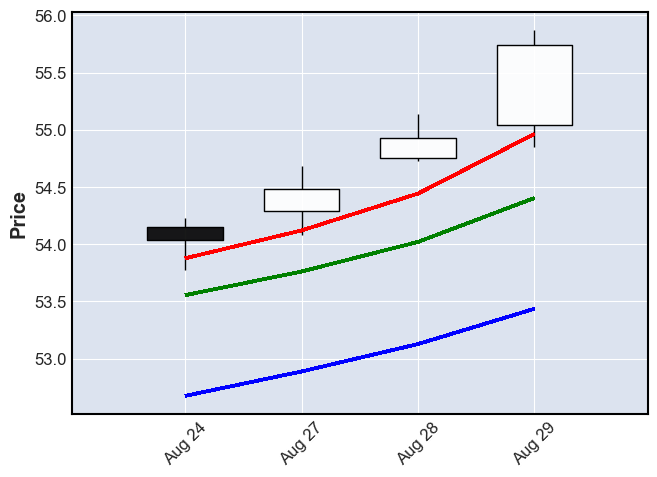

,opens,high,low,close,ema4,ema8,ema16,labels,prediction,Datetime,profit
In,,,,,,,,,,,
24,54.150002,54.224998,53.777500,54.040001,53.876628,53.554105,52.674061,nn,nn,2018-08-24,0.654245
25,54.287498,54.685001,54.082500,54.485001,54.119977,53.760971,52.887113,nn,nn,2018-08-27,0.654245
26,54.752499,55.134998,54.730000,54.924999,54.441986,54.019644,53.126864,nn,nn,2018-08-28,0.654245
27,55.037498,55.872501,54.852501,55.744999,54.963191,54.403056,53.434880,55.8725,55.7892,2018-08-29,0.654245


In [69]:
import mplfinance as mpf

if mover == 0 and switch == False:
    mover = 0
    print("Row start: ",mover) 
    print("Trade: ", 1)
    switch = True
else:
    mover += 4
    print("Row start: ",mover) 
    print("Trade: " + str(int(mover/4)) + " (" + str(int(len(trades_df)/4)) + ")") 

lower = mover
upper = mover + 4

selected_df = trades_df.iloc[lower:upper,:]
 
#Get EMAs
dates = selected_df['Datetime']
ema4 = selected_df['ema4']
ema8 = selected_df['ema8']
ema16 = selected_df['ema16']
datepairs_ema4 = [(d1,d2) for d1,d2 in zip(dates,ema4)]
datepairs_ema8 = [(d1,d2) for d1,d2 in zip(dates,ema8)]
datepairs_ema16 = [(d1,d2) for d1,d2 in zip(dates,ema16)]
datepairs_ema16

#Format Dataframe
quotes = selected_df.iloc[:,:10]
quotes['Datetime'] = quotes['Datetime'].astype('datetime64')
quotes = quotes.set_index('Datetime')
quotes = quotes.iloc[:4,:4]
quotes.columns=['open','high','low','close']

#Print it
budget = 10000
entry = selected_df.iloc[2,1]
profit = selected_df.iloc[3,-1]
real_profit = round((budget / entry)*profit,2)
print("\nBudget: ",budget)

print("\nEntry price: ",round(selected_df.iloc[2,1],2))
print("Label (target): ",round(selected_df.iloc[3,7],2))
print("Model prediction: ",round(selected_df.iloc[3,8],2))
print("\nProfit: ",round(selected_df.iloc[3,-1],3))
print("Real Profit: " + str(real_profit) + " dollars (budget " + str(budget) + ")")

#two_points  = [('2018-07-31',48),('2018-08-01',49)]

#label = selected_df.iloc[3,7]
mpf.plot(quotes,type='candle',alines=dict(alines=[datepairs_ema4,datepairs_ema8,datepairs_ema16],colors=['r','g','b']))

selected_df

# Make Prediction (please refer to a page 03_Model_Prediction)

Bellow code makes prediction on most recent data, pulled from yahoo finance, please refer to page 03_model_prediction

<b>Initialize libraries and define custom functions</b>

In [369]:
import tensorflow as tf
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def sign_penalty(y_true,y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred,0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                   )
    
    return(tf.reduce_mean(loss,axis=-1))

tf.keras.losses.sign_penalty = sign_penalty

def norm_df(pred1):
    df_temp = pd.DataFrame()
    try:
        pred1 = pred1.drop('Date',axis=1)
    except:
        pass
    pred_np = pred1.to_numpy()
    maxv = np.max(pred_np)
    minv = np.min(pred_np)
    df_temp = (pred1.iloc[:,:]-minv)/(maxv-minv)
    
    return df_temp, maxv,minv
def revert_df(df,maxv,minv):
    df_temp = pd.DataFrame() 
    df_temp = (df.iloc[:,:]*(maxv-minv))+minv
    
    return df_temp
def revert_prediction(value,maxv,minv):
    
    return (value * (maxv-minv))+minv
def MakePred(series,model):
    pr = series.to_numpy()
    series2=np.array([[pr]])   
    pred = tf.data.Dataset.from_tensor_slices(series2)
    prediction = model.predict(pred)
        
    return prediction  
def Predict(pred):
    df_temp1, maxv, minv = norm_df(pred)
    pr = MakePred(df_temp1,model)
    prediction = revert_prediction(pr,maxv,minv)
    prediction = np.squeeze(prediction)
    #print("Prediction is: ",prediction)
    return prediction


<b>Load data from stock market</b>

In [370]:
stock = yf.download('aapl', 
                      start='2021-10-27', 
                      end='2021-12-30', 
                      interval="1d",
                      progress=False,
)
#Set Indicators
stock['EMA4'] = talib.EMA(stock['Close'], timeperiod=4)
stock['EMA8'] = talib.EMA(stock['Close'], timeperiod=8)
stock['EMA16'] = talib.EMA(stock['Close'], timeperiod=16)
stock = stock.drop(labels=['Adj Close','Volume'],axis=1)


#Get final dataframe
trading_formation = stock.iloc[len(stock)-3:]
trading_formation = trading_formation.reset_index()
    
#print("Data loaded in dataframe trading_formation")

#Check condition
if ((trading_formation.iloc[2,1]>trading_formation.iloc[2-1,1])\
    and (trading_formation.iloc[2,1] > trading_formation.iloc[2,4])\
    and (trading_formation.iloc[2,4] > trading_formation.iloc[2,5])\
    and (trading_formation.iloc[2,5] > trading_formation.iloc[2,6])):     
    print("Trading condition passed, you can make prediction")


else:
    print("condition NOT passed, do NOT trade")

condition NOT passed, do NOT trade


<b>Make Prediction</b>

In [372]:
trading_formation

,Date,Open,High,Low,Close,EMA4,EMA8,EMA16
0,2021-12-27,177.089996,180.419998,177.070007,180.330002,176.960362,175.308112,172.510578
1,2021-12-28,180.160004,181.330002,178.529999,179.289993,177.892214,176.192975,173.308156
2,2021-12-29,179.330002,180.630005,178.139999,179.380005,178.487331,176.901204,174.022491


In [374]:
penalisation = 0.049

pred = Predict(trading_formation)
print("Raw prediction is: ",pred)
ppred = round(pred-penalisation,5)
print("Penalised Prediction is: ",ppred)

Raw prediction is:  181.24554
Penalised Prediction is:  181.19654
